### Start

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import fisher_exact, mannwhitneyu

import shap
import xgboost
import inspect

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns





c:\Users\pu.0580\Desktop\Projects\Projects\bacilli_turin_boattini_2024\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv('../data/neg_bacilli_turin_2024.txt', delimiter='\t')
print(df)
for name in df.columns:
    print(name)

### Missing Data

In [ ]:
print("Total missing # :", df.isna().sum().sum())
print("Total missing % :", 100* df.isna().sum().sum() / (df.shape[0]*df.shape[1]) )
df.fillna(0, inplace=True)
print("Total missing # :", df.isna().sum().sum())
print("Total missing % :", 100* df.isna().sum().sum() / (df.shape[0]*df.shape[1]) )

### Summary Stats

In [ ]:
def calculate_se_proportion(p, n):
    return np.sqrt((p * (1 - p)) / n).round(2)

In [ ]:
def create_summary_table(df):
    """ Generate summary table.
    Args:
    df (DataFrame): The DataFrame for which to generate the summary table.
    Returns:
    DataFrame: The summary table."""

    # Generate summary statistics for ALL columns
    summary_table = df.describe()
    # Transpose the summary table
    summary_table = summary_table.T
    # Round all values to two decimal points
    summary_table = summary_table.round(2)
    # Create 'Mean ± Std' column
    summary_table['Mean ± Std'] = summary_table.apply(lambda row: f"{row['mean']} ± {row['std']}", axis=1)
    # Create 'Median [IQR]' column
    summary_table['Median [IQR]'] = summary_table.apply(lambda row: f"{row['50%']} [{row['25%']}-{row['75%']}]", axis=1)
    # Create 'Proportion ± SE' column
    summary_table['Proportion ± SE'] = summary_table.apply(lambda row: f"{row['mean']} ± {calculate_se_proportion(row['mean'], row['count'])}", axis=1)
    # Create 'SE_Error_Flag' column
    summary_table['SE_Error_Flag'] = summary_table['Proportion ± SE'].apply(lambda row: 1 if 'nan' in str(row) else 0)
    # Reset the index
    summary_table.reset_index(inplace=True)
    # Create 'Row_Number' column
    summary_table['Row_Number'] = summary_table.index + 1
    # Drop unnecessary columns
    summary_table.drop(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], axis=1, inplace=True)

    return summary_table

In [ ]:
summary_table = create_summary_table(df)
summary_table.to_csv('../data/summary_table.csv')
summary_table

### Summary Stats + Fisher's Exat Test | Wilcoxon/Mann-Whitney Test

### Positive >2 cultures  || +50%

In [ ]:
df_cult_pos = df[df['Positive_2culture_50perc'] == 1] # 43 out of 63
summary_table = create_summary_table(df_cult_pos)
summary_table.to_csv('../data/summary_table_cult_pos.csv')

In [ ]:
df_cult_neg = df[df['Positive_2culture_50perc'] == 0] # 20 out of 63
summary_table = create_summary_table(df_cult_neg)
summary_table.to_csv('../data/summary_table_cult_neg.csv')

In [ ]:
exclude_cols = ['Positive_2culture_50perc', 'pat_id']
binary_results = []
numeric_results = []

In [ ]:
for col in df.columns:
    if col not in exclude_cols:
        if df[col].nunique() <= 2:
            filtered_col = df[col].dropna().astype(int)
            if filtered_col.nunique() == 2:
                contingency_table = pd.crosstab(df['Positive_2culture_50perc'], filtered_col)
                odds_ratio , p_value = fisher_exact(contingency_table)
                binary_results.append((col, odds_ratio, p_value))
            else:
                print(f"Warning: Colunm '{col}' does not exactly 2 unique values. Dropping it..." )
        else:
            group_1 = df[df['Positive_2culture_50perc'] == 1][col]
            group_2 = df[df['Positive_2culture_50perc'] == 0][col]
            _ , p_value = mannwhitneyu(group_1, group_2, alternative='two-sided')
            numeric_results.append((col, p_value))

In [ ]:
print("Numeric Variables (Wilcoxon/Mann-Whitney Test): ")
for result in numeric_results:
    print(f"{result[0]} , p-value: {result[1]}" )

In [ ]:
print("Binary Variables (Fisher's Exact Test): ")
for result in binary_results:
    print(f"{result[0]} - Odds Ratio: {result[1]}, p-value: {result[2]}" )

### In-Hospital Mortality

### Summary Stats + Fisher's Exat Test | Wilcoxon/Mann-Whitney Test

In [ ]:
df_hosp_mort_pos = df[df['Mortality_hospital'] == 1] # 10 out of 63
summary_table = create_summary_table(df_hosp_mort_pos)
summary_table.to_csv('../data/summary_table_hosp_mort_pos.csv')

In [ ]:
df_hosp_mort_neg = df[df['Mortality_hospital'] == 0] # 53 out of 63
summary_table = create_summary_table(df_hosp_mort_neg)
summary_table.to_csv('../data/summary_table_hosp_mort_neg.csv')

In [ ]:
exclude_cols = ['Mortality_hospital', 'pat_id', 'Amoxicillin_clavulanate_including', 'Metronidazole_including', 'Mortality_30_days', 'Mortality_14_days']
binary_results = []
numeric_results = []

In [ ]:
for col in df.columns:
    if col not in exclude_cols:
        if df[col].nunique() <= 2:
            filtered_col = df[col].dropna().astype(int)
            if filtered_col.nunique() == 2:
                contingency_table = pd.crosstab(df['Mortality_hospital'], filtered_col)
                odds_ratio , p_value = fisher_exact(contingency_table)
                binary_results.append((col, odds_ratio, p_value))
            else:
                print(f"Warning: Colunm '{col}' does not exactly 2 unique values. Dropping it..." )
        else:
            group_1 = df[df['Mortality_hospital'] == 1][col]
            group_2 = df[df['Mortality_hospital'] == 0][col]
            _ , p_value = mannwhitneyu(group_1, group_2, alternative='two-sided')
            numeric_results.append((col, p_value))

In [ ]:
print("Numeric Variables (Wilcoxon/Mann-Whitney Test): ")
for result in numeric_results:
    print(f"{result[0]} , p-value: {result[1]}" )

In [ ]:
print("Binary Variables (Fisher's Exact Test): ")
for result in binary_results:
    print(f"{result[0]} - Odds Ratio: {result[1]}, p-value: {result[2]}" )

### Model: XGBoost

In [ ]:
df = pd.read_csv('../data/neg_bacilli_turin_2024.txt', delimiter='\t')
df.fillna(0, inplace=True)

In [ ]:
# columns_to_drop = ['pat_id', 'Amoxicillin_clavulanate_including', 'Metronidazole_including', 'Mortality_30_days', 'Mortality_14_days']
columns_to_drop = ['pat_id', 'Amoxicillin_clavulanate_including', 'Metronidazole_including', 'Mortality_30_days', 'Mortality_14_days', 'LOS_days']
df = df.drop(columns=columns_to_drop)

In [ ]:
y = df['Mortality_hospital']
X = df.drop(columns=['Mortality_hospital'])


In [ ]:
X100 = shap.utils.sample(X, 100)

In [ ]:
df.shape

In [ ]:
y[y==1]

In [ ]:
model = xgboost.XGBClassifier(nestimators=100, max_depth=2, objective = "binary:logistic").fit(X, y)
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

In [ ]:
shap_values.display_data = X.values

In [ ]:
shap.initjs()
shap.force_plot(shap_values[10])


In [ ]:
shap.force_plot(shap_values[11])


In [ ]:
shap.force_plot(shap_values[14])


In [ ]:
shap.force_plot(shap_values[41])


In [ ]:
shap.force_plot(shap_values[42])


In [ ]:
shap.force_plot(shap_values[36])


In [ ]:
shap.force_plot(shap_values[35])


In [ ]:
shap.force_plot(shap_values[2])



In [ ]:
shap.force_plot(shap_values[3])


In [ ]:
shap.force_plot(shap_values[5])


In [ ]:
shap.force_plot(shap_values[50])


In [ ]:
shap.force_plot(shap_values[60])


In [ ]:
shap.force_plot(shap_values[27])


In [ ]:
shap.plots.bar(shap_values)


In [ ]:
shap.plots.bar(shap_values.abs.max(0))


In [ ]:
shap.plots.beeswarm(shap_values)


In [ ]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

In [ ]:
shap.plots.heatmap(shap_values, max_display=10, plot_width=8)

### Principal Component Analysis

In [2]:
df = pd.read_csv('../data/neg_bacilli_turin_2024.txt', delimiter='\t')
df.fillna(0, inplace=True)


In [3]:
columns_to_drop = ['pat_id', 'Amoxicillin_clavulanate_including', 'Metronidazole_including', 'Mortality_14_days', 'Mortality_30_days', 'LOS_days']
df = df.drop(columns=columns_to_drop)

In [4]:
numerical_features = df.select_dtypes(include=['float64', 'int64'])
numerical_features = numerical_features.drop(columns=['Mortality_hospital'])

binary_numerical_features = [col for col in numerical_features.columns if numerical_features[col].nunique() == 2]

non_binary_numerical_features = numerical_features.drop(columns=binary_numerical_features)

scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(numerical_features)

In [5]:
df[numerical_features.columns] = scaled_numerical_features

In [6]:
df.shape

(63, 74)

In [7]:
numerical_features = df.drop(columns=['Mortality_hospital']).select_dtypes(include=['float64', 'int64'])
numerical_features.shape

(63, 73)

In [16]:
pca = PCA(n_components=0.90) 
pca.fit(numerical_features)


PCA(n_components=0.9)

In [17]:
principal_components = pca.transform(numerical_features)
principal_components_df = pd.DataFrame(data=principal_components, 
                                       columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])


In [18]:
loadings = pca.components_
loadings_df = pd.DataFrame(loadings, columns=numerical_features.columns)


In [19]:
for i, component in enumerate(loadings_df.iterrows(), start=1):
    print(f"Principal Component {i} Loadings:")
    print(component)
    print("\n")

Principal Component 1 Loadings:
(0, STEMA                     0.130714
Achromobacter             0.092052
Ochrobactrum             -0.072545
Aeromonas                -0.110264
Burkolderia              -0.012718
                            ...   
Colistin_including        0.019321
T_S_including             0.163781
Azitromicine_including   -0.060559
Cefiderocol_including    -0.006259
BSI_relapse               0.055581
Name: 0, Length: 73, dtype: float64)


Principal Component 2 Loadings:
(1, STEMA                     0.116214
Achromobacter             0.047375
Ochrobactrum              0.089022
Aeromonas                -0.056569
Burkolderia              -0.122800
                            ...   
Colistin_including        0.083722
T_S_including             0.156290
Azitromicine_including   -0.016209
Cefiderocol_including     0.077821
BSI_relapse              -0.036307
Name: 1, Length: 73, dtype: float64)


Principal Component 3 Loadings:
(2, STEMA                     0.124609
Achromoba

In [27]:
loadings_df.index = loadings_df.index + 1

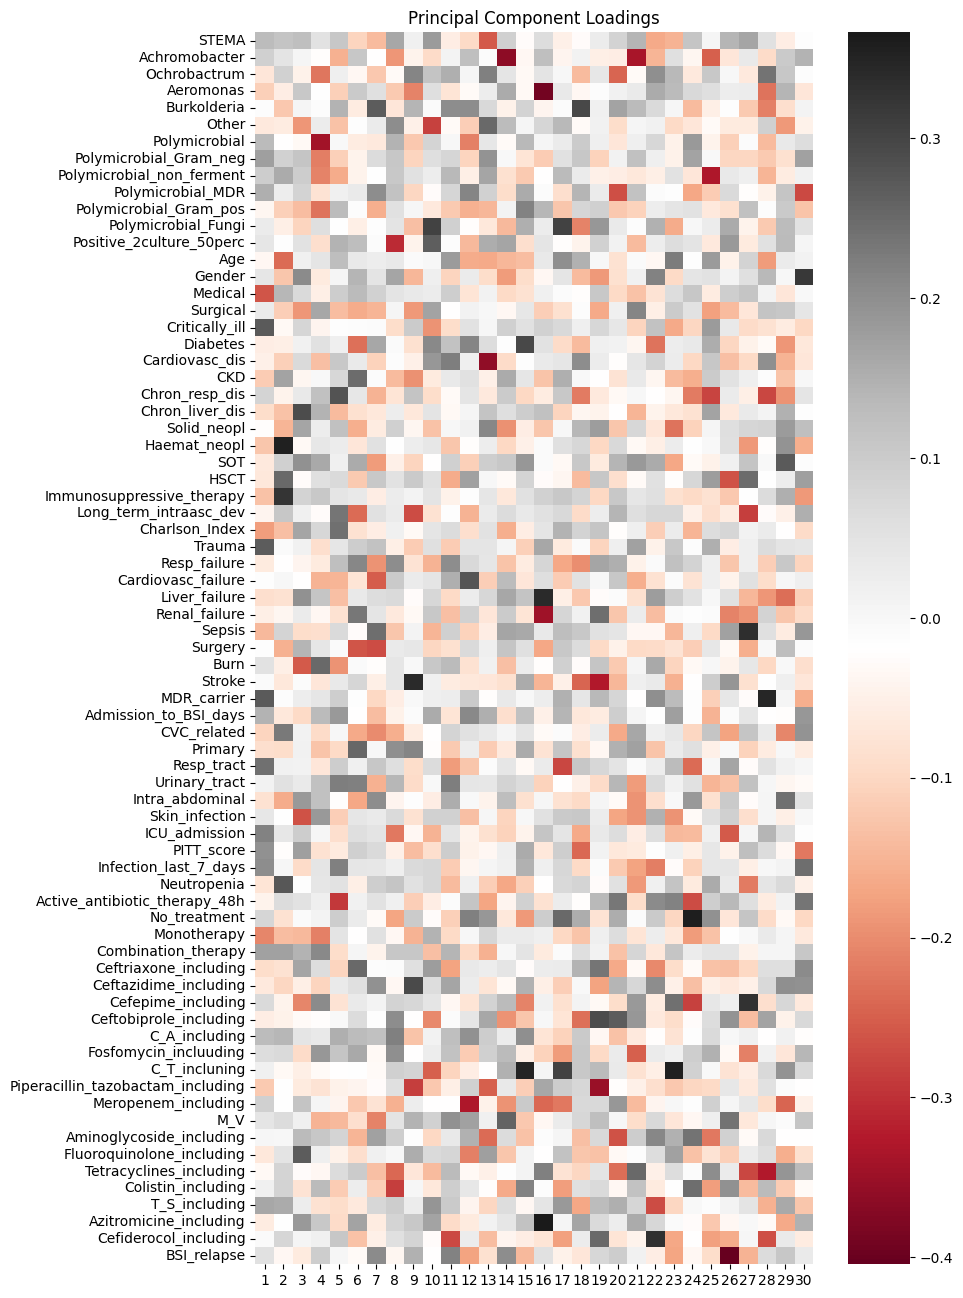

In [29]:
plt.figure(figsize=(9, 16))
sns.heatmap(loadings_df.T, cmap='RdGy', annot=False, fmt=".1f", cbar=True)
plt.title('Principal Component Loadings')
plt.xlabel(None)  
plt.ylabel(None)  
plt.show()

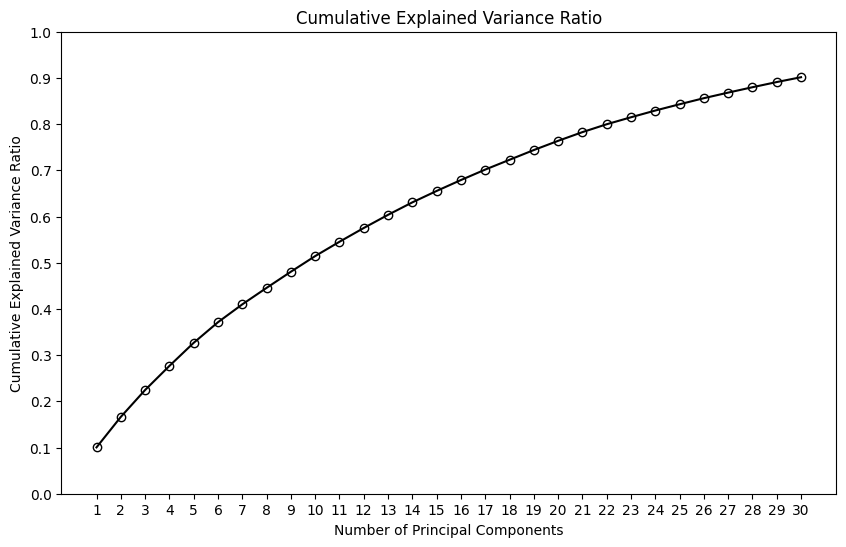

In [40]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)


plt.figure(figsize=(10, 6))
plt.plot(range(len(cumulative_variance_ratio)), cumulative_variance_ratio, marker='o', linestyle='-', color='black', markerfacecolor='none')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xticks(range(len(cumulative_variance_ratio)), range(1, len(cumulative_variance_ratio) + 1))
plt.yticks(np.arange(0, 1.1, 0.1))  # Start y-axis from 0 and include increments of 0.1
plt.grid(False)
plt.show()


In [ ]:
principal_components_df

In [30]:
y = df['Mortality_hospital']

correlation_with_y = principal_components_df.apply(lambda col: col.corr(y))


In [31]:
correlation_with_y_sorted = correlation_with_y.abs().sort_values(ascending=False)


In [32]:
print("Correlation with Output Variable (Absolute Values):")
print(correlation_with_y_sorted)

Correlation with Output Variable (Absolute Values):
PC5     0.378601
PC17    0.297409
PC15    0.277807
PC22    0.239981
PC4     0.229526
PC25    0.228419
PC21    0.204055
PC28    0.182023
PC30    0.177093
PC11    0.114191
PC20    0.102565
PC7     0.101573
PC12    0.094978
PC23    0.090514
PC19    0.088573
PC9     0.064256
PC6     0.059052
PC14    0.057406
PC3     0.052032
PC27    0.051583
PC16    0.048439
PC8     0.037877
PC18    0.036694
PC24    0.031040
PC10    0.028785
PC26    0.023514
PC29    0.018790
PC13    0.015849
PC2     0.009921
PC1     0.008529
dtype: float64


In [33]:
pca_with_y = pd.concat([principal_components_df, y], axis=1)


In [34]:
mean_loadings_by_y = pca_with_y.groupby('Mortality_hospital').mean()


In [35]:
print("Mean Loadings by Output Variable Group:")
print(mean_loadings_by_y)

Mean Loadings by Output Variable Group:
                         PC1       PC2       PC3       PC4       PC5  \
Mortality_hospital                                                     
0                  -0.010024  0.009458  0.046595 -0.194481 -0.314266   
1                   0.053128 -0.050125 -0.246956  1.030751  1.665611   

                         PC6       PC7       PC8       PC9      PC10  ...  \
Mortality_hospital                                                    ...   
0                   0.046280  0.074093 -0.026562  0.044567 -0.019661  ...   
1                  -0.245283 -0.392694  0.140780 -0.236206  0.104203  ...   

                        PC21      PC22      PC23      PC24      PC25  \
Mortality_hospital                                                     
0                   0.103978  0.116454 -0.041262  0.013912 -0.098728   
1                  -0.551085 -0.617208  0.218690 -0.073736  0.523261   

                        PC26      PC27      PC28      PC29      PC30  
Mo

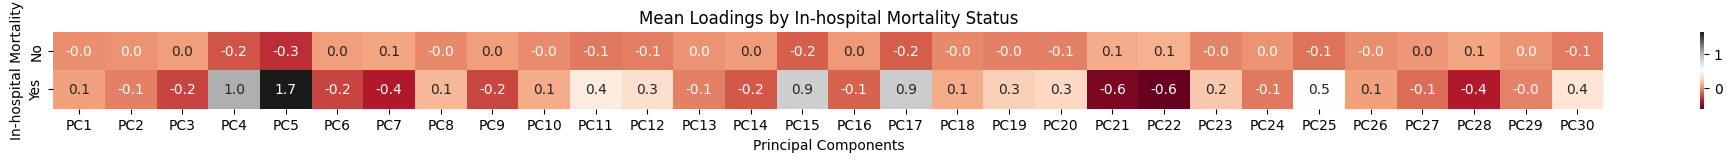

In [36]:
mean_loadings_by_y.index = mean_loadings_by_y.index.map({0: 'No', 1: 'Yes'})


plt.figure(figsize=(25, 1))
sns.heatmap(mean_loadings_by_y, cmap='RdGy', annot=True, fmt=".1f", cbar=True)
plt.title('Mean Loadings by In-hospital Mortality Status')
plt.xlabel('Principal Components')
plt.ylabel('In-hospital Mortality')
plt.show()

In [37]:
top_features_by_pc = {}

for pc in loadings_df.index:
    top_features_by_pc[pc] = loadings_df.loc[pc].abs().nlargest(5).index.tolist()

for pc, features in top_features_by_pc.items():
    print(f"Principal Component {pc}: {features}")


Principal Component 1: ['Critically_ill', 'MDR_carrier', 'Trauma', 'Medical', 'Resp_tract']
Principal Component 2: ['Haemat_neopl', 'Immunosuppressive_therapy', 'Neutropenia', 'HSCT', 'Age']
Principal Component 3: ['Chron_liver_dis', 'Fluoroquinolone_including', 'Skin_infection', 'Burn', 'Cefepime_including']
Principal Component 4: ['Polymicrobial', 'Burn', 'Polymicrobial_Gram_pos', 'Ochrobactrum', 'Polymicrobial_Gram_neg']
Principal Component 5: ['Active_antibiotic_therapy_48h', 'Chron_resp_dis', 'Charlson_Index', 'Long_term_intraasc_dev', 'Urinary_tract']
Principal Component 6: ['Surgery', 'Primary', 'Ceftriaxone_including', 'CKD', 'Long_term_intraasc_dev']
Principal Component 7: ['Surgery', 'Burkolderia', 'Cardiovasc_failure', 'Sepsis', 'M_V']
Principal Component 8: ['Positive_2culture_50perc', 'Colistin_including', 'Tetracyclines_including', 'ICU_admission', 'C_A_including']
Principal Component 9: ['Stroke', 'Ceftazidime_including', 'Piperacillin_tazobactam_including', 'Long_term_i